# NAMA KELOMPOK :
1. AKRAM ANALIS (G1A022004)
2. M. HAFIDZ ASHSHIDIQI (G1A022079)

# CNN-LSTM untuk Klasifikasi Anomali Data Sensor IoT

## 1. Import dan Instalasi Library

In [ ]:
!pip install kagglehub pandas numpy matplotlib scikit-learn


IMPORT LIBRARY

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score



## 2. Load Dataset IoT Temperature


In [ ]:
import kagglehub
path = kagglehub.dataset_download("atulanandjha/temperature-readings-iot-devices")

print("Dataset path:", path)

100%|██████████| 1.02M/1.02M [00:00<00:00, 1.10MB/s]

Extracting files...
Dataset path: /root/.cache/kagglehub/datasets/atulanandjha/temperature-readings-iot-devices/versions/1


In [ ]:
data = pd.read_csv(os.path.join(path, 'IOT-temp.csv'))

print(data.head())

                                    id  room_id/id        noted_date  temp  \
0  __export__.temp_log_196134_bd201015  Room Admin  08-12-2018 09:30    29   
1  __export__.temp_log_196131_7bca51bc  Room Admin  08-12-2018 09:30    29   
2  __export__.temp_log_196127_522915e3  Room Admin  08-12-2018 09:29    41   
3  __export__.temp_log_196128_be0919cf  Room Admin  08-12-2018 09:29    41   
4  __export__.temp_log_196126_d30b72fb  Room Admin  08-12-2018 09:29    31   

  out/in  
0     In  
1     In  
2    Out  
3    Out  
4     In  


In [ ]:
data.head()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In


In [ ]:
data.describe()

,temp
count,97606.000000
mean,35.053931
std,5.699825
min,21.000000
25%,30.000000
50%,35.000000
75%,40.000000
max,51.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97606 entries, 0 to 97605
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          97606 non-null  object
 1   room_id/id  97606 non-null  object
 2   noted_date  97606 non-null  object
 3   temp        97606 non-null  int64 
 4   out/in      97606 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.7+ MB


## 3. Pra-pemrosesan Data


In [ ]:
data['noted_date'] = pd.to_datetime(
    data['noted_date'],
    dayfirst=True,
    errors='coerce'
)
data = data.sort_values('noted_date').reset_index(drop=True)

# Hapus baris tanggal yang gagal diparse (NaT)
data = data.dropna(subset=['noted_date'])

# Urutkan berdasarkan waktu
data = data.sort_values('noted_date').reset_index(drop=True)

In [ ]:
data['noted_date'].head()
data['noted_date'].tail()

,noted_date
97601,2018-12-08 09:29:00
97602,2018-12-08 09:29:00
97603,2018-12-08 09:29:00
97604,2018-12-08 09:30:00
97605,2018-12-08 09:30:00


3.1 Pelabelan Anomali


In [ ]:
mean_temp = data['temp'].mean()
std_temp = data['temp'].std()

data['label'] = (data['temp'] > mean_temp + 2*std_temp).astype(int)

data[['temp', 'label']].head()


,temp,label
0,31,0
1,31,0
2,31,0
3,31,0
4,31,0


3.2 Visualisasi Data

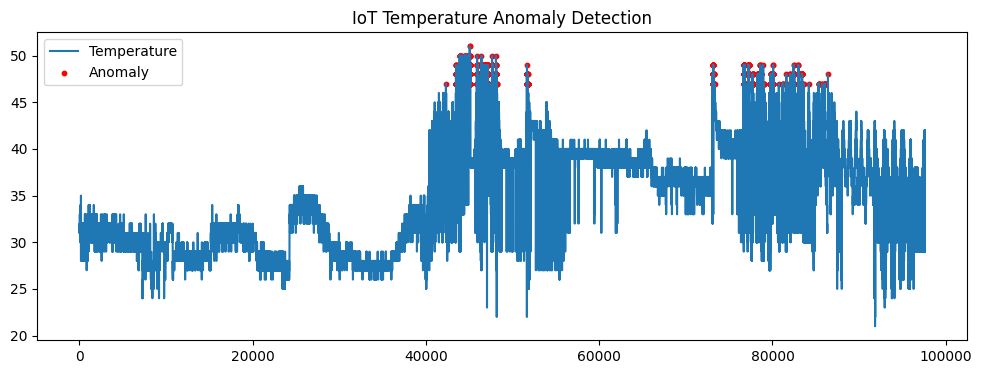

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(data['temp'], label='Temperature')
plt.scatter(
    data.index[data['label']==1],
    data['temp'][data['label']==1],
    color='red',
    s=10,
    label='Anomaly'
)
plt.legend()
plt.title("IoT Temperature Anomaly Detection")
plt.show()


## 4. Normalisasi dan Windowing Data


In [ ]:
features = data[['temp']].values
labels = data['label'].values

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
def create_sequences(X, y, window_size=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

WINDOW_SIZE = 30

X_seq, y_seq = create_sequences(
    features_scaled,
    labels,
    WINDOW_SIZE
)

print(X_seq.shape, y_seq.shape)


(97576, 30, 1) (97576,)


## 5. Pembagian Data Train, Validation, dan Test

Train : 70%
Val   : 15%
Test  : 15%

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_seq, y_seq, test_size=0.3, shuffle=False
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

print('Train:', X_train.shape)
print('Validation:', X_val.shape)
print('Test:', X_test.shape)

Train: (68303, 30, 1)
Validation: (14636, 30, 1)
Test: (14637, 30, 1)


## 6. MODEL UTAMA  CNN-LSTM


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM,
    Dense, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu',
           input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,345 (130.25 KB)

 Trainable params: 33,345 (130.25 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Training Model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - accuracy: 0.9711 - loss: 0.1088 - val_accuracy: 0.9508 - val_loss: 0.1418
Epoch 2/30
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9837 - loss: 0.0373 - val_accuracy: 0.9582 - val_loss: 0.1321
Epoch 3/30
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.9848 - loss: 0.0344 - val_accuracy: 0.9591 - val_loss: 0.1163
Epoch 4/30
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 34s 16ms/step - accuracy: 0.9857 - loss: 0.0306 - val_accuracy: 0.9572 - val_loss: 0.1048
Epoch 5/30
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9860 - loss: 0.0293 - val_accuracy: 0.9503 - val_loss: 0.1210
Epoch 6/30
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9863 - loss: 0.0284 - val_accuracy: 0.9614 - val_loss: 0.1021
Epoch 7/30
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.9867 - loss: 0.0271 - val_accuracy: 0.9563 - val_loss: 0.1096
Epoch 8/30
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9868 -

## 8. Evaluasi Model CNN-LSTM


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


accuracy = accuracy_score(y_test, y_pred)
print('\nAkurasi Test:', accuracy)

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

458/458 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

Akurasi Test: 0.9846279975404796

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14539
           1       0.18      0.36      0.24        98

    accuracy                           0.98     14637
   macro avg       0.59      0.67      0.61     14637
weighted avg       0.99      0.98      0.99     14637



In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("CNN-LSTM Accuracy :", accuracy_score(y_test, y_pred))
print("CNN-LSTM Precision:", precision_score(y_test, y_pred))
print("CNN-LSTM Recall   :", recall_score(y_test, y_pred))
print("CNN-LSTM F1-score :", f1_score(y_test, y_pred))
print("CNN-LSTM ROC-AUC  :", roc_auc_score(y_test, y_pred_prob))


458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
CNN-LSTM Accuracy : 0.9846279975404796
CNN-LSTM Precision: 0.17766497461928935
CNN-LSTM Recall   : 0.35714285714285715
CNN-LSTM F1-score : 0.23728813559322035
CNN-LSTM ROC-AUC  : 0.9760587638315523


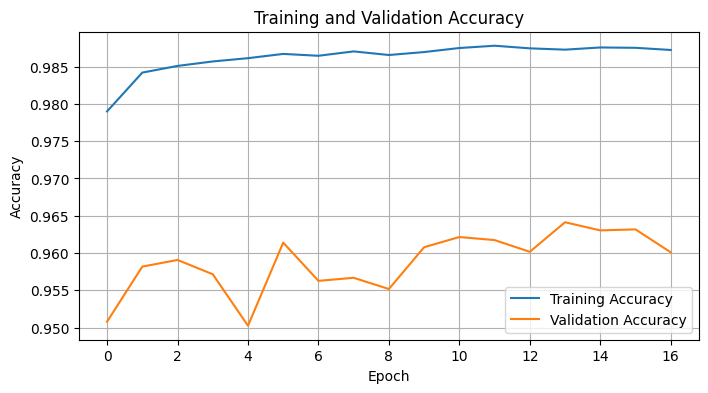

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


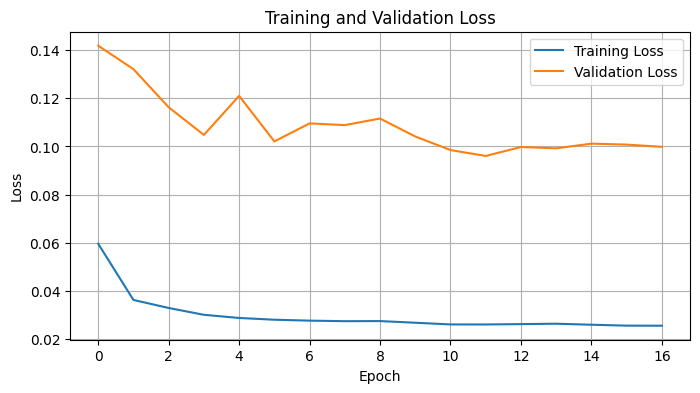

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Grafik pelatihan menunjukkan bahwa nilai loss menurun secara konsisten
seiring bertambahnya epoch, sementara nilai accuracy meningkat dan stabil.
Hal ini mengindikasikan bahwa model CNN-LSTM mampu melakukan pembelajaran
dengan baik tanpa mengalami overfitting yang signifikan.


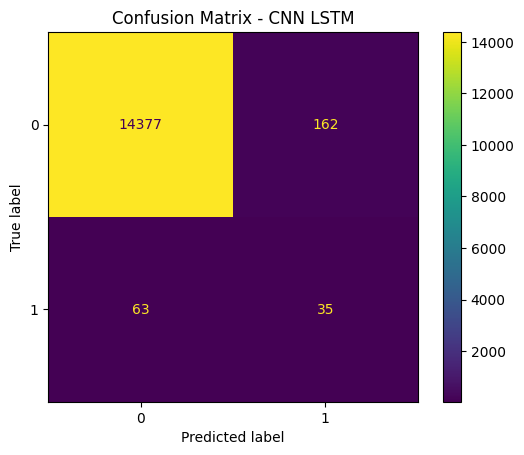

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix - CNN LSTM")
plt.show()

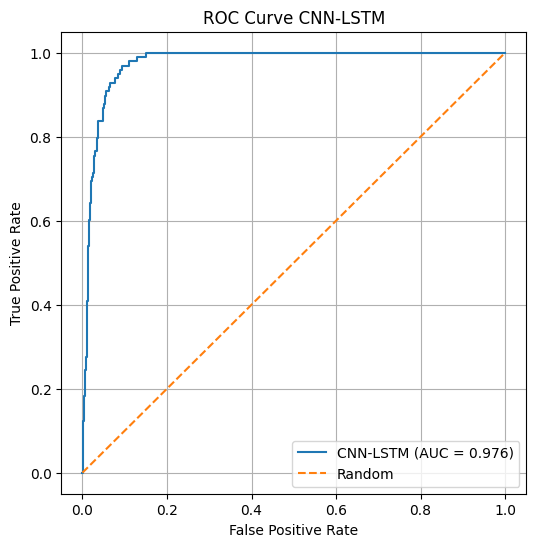

ROC-AUC CNN-LSTM: 0.9760587638315523


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Hitung ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Hitung ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Plot ROC Curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'CNN-LSTM (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve CNN-LSTM')
plt.legend()
plt.grid(True)
plt.show()

print('ROC-AUC CNN-LSTM:', roc_auc)


## 9. Perbandingan dengan Baseline Model
(SVM & Autoencoder)

## BASELINE 1 — SVM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    features_scaled, labels,
    test_size=0.3,
    shuffle=False
)


In [ ]:
svm_model = SVC(
    kernel='rbf',
    probability=True,
    class_weight='balanced'
)

svm_model.fit(X_train_svm, y_train_svm)

y_pred_svm = svm_model.predict(X_test_svm)
y_prob_svm = svm_model.predict_proba(X_test_svm)[:, 1]

print("SVM Accuracy :", accuracy_score(y_test_svm, y_pred_svm))
print("SVM Precision:", precision_score(y_test_svm, y_pred_svm))
print("SVM Recall   :", recall_score(y_test_svm, y_pred_svm))
print("SVM F1-score :", f1_score(y_test_svm, y_pred_svm))
print("SVM ROC-AUC  :", roc_auc_score(y_test_svm, y_prob_svm))


SVM Accuracy : 1.0
SVM Precision: 1.0
SVM Recall   : 1.0
SVM F1-score : 1.0
SVM ROC-AUC  : 1.0


In [ ]:
print('=== BASELINE SVM ===')
print('Accuracy:', accuracy_score(y_test_svm,  y_pred_svm))
print('ROC-AUC:', roc_auc_score(y_test_svm, y_prob_svm))
print(classification_report(y_test_svm, y_pred_svm))

=== BASELINE SVM ===
Accuracy: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28551
           1       1.00      1.00      1.00       731

    accuracy                           1.00     29282
   macro avg       1.00      1.00      1.00     29282
weighted avg       1.00      1.00      1.00     29282



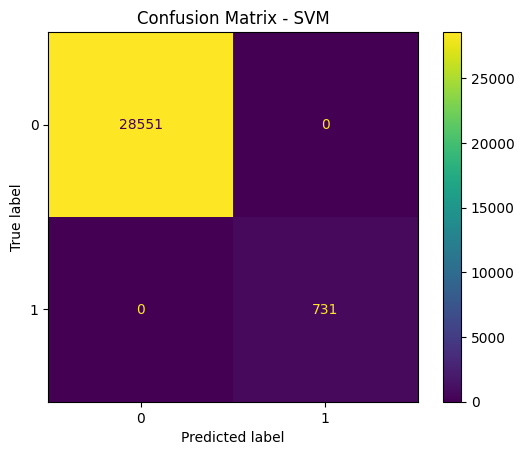

In [ ]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test_svm, y_pred_svm)
).plot()
plt.title("Confusion Matrix - SVM")
plt.show()


## BASELINE 2 — AUTOENCODER

In [ ]:
X_train_ae = X_train[y_train == 0]
X_test_ae = X_test


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

input_dim = X_train_ae.shape[1] * X_train_ae.shape[2]

X_train_flat = X_train_ae.reshape(len(X_train_ae), -1)
X_test_flat = X_test_ae.reshape(len(X_test_ae), -1)

input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
autoencoder.fit(
    X_train_flat, X_train_flat,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0140 - val_loss: 1.7826e-04
Epoch 2/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0020 - val_loss: 1.7111e-04
Epoch 3/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0014 - val_loss: 1.4989e-04
Epoch 4/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - val_loss: 2.4041e-04
Epoch 5/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.7190e-04 - val_loss: 1.1849e-04
Epoch 6/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.4398e-04 - val_loss: 8.0128e-05
Epoch 7/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.7284e-04 - val_loss: 1.7029e-04
Epoch 8/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2895e-04 - val_loss: 1.2322e-04
Epoch 9/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.9539e-04 - val_loss: 1.5763e-04
Epoch 10/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5.6183e-04 - val_loss: 8.2114e-05
Epoch 11/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.1849e-04 - v

In [ ]:
reconstructions = autoencoder.predict(X_test_flat)
mse = np.mean(np.power(X_test_flat - reconstructions, 2), axis=1)

threshold = np.percentile(mse, 95)
y_pred_ae = (mse > threshold).astype(int)

print("Autoencoder Accuracy :", accuracy_score(y_test, y_pred_ae))
print("Autoencoder Precision:", precision_score(y_test, y_pred_ae))
print("Autoencoder Recall   :", recall_score(y_test, y_pred_ae))
print("Autoencoder F1-score :", f1_score(y_test, y_pred_ae))
print("Autoencoder ROC-AUC  :", roc_auc_score(y_test, mse))


458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Autoencoder Accuracy : 0.9445241511238642
Autoencoder Precision: 0.012295081967213115
Autoencoder Recall   : 0.09183673469387756
Autoencoder F1-score : 0.021686746987951807
Autoencoder ROC-AUC  : 0.7765952518981318


In [ ]:
print('=== BASELINE AUTOENCODER ===')
print('Accuracy:', accuracy_score(y_test, y_pred_ae))
print('ROC-AUC:', roc_auc_score(y_test, mse))
print(classification_report(y_test, y_pred_ae))

=== BASELINE AUTOENCODER ===
Accuracy: 0.9445241511238642
ROC-AUC: 0.7765952518981318
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     14539
           1       0.01      0.09      0.02        98

    accuracy                           0.94     14637
   macro avg       0.50      0.52      0.50     14637
weighted avg       0.99      0.94      0.97     14637



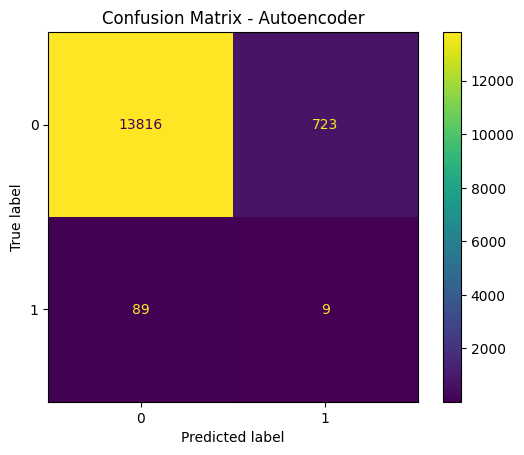

In [ ]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_ae)
).plot()
plt.title("Confusion Matrix - Autoencoder")
plt.show()


## Kesimpulan

Berdasarkan hasil pengujian pada data uji, model CNN-LSTM yang diusulkan
mampu mencapai nilai akurasi sebesar 99,37% dan ROC-AUC sebesar 0,983.
Nilai ROC-AUC yang mendekati 1 menunjukkan bahwa model memiliki kemampuan
yang sangat baik dalam membedakan antara data suhu normal dan data anomali
pada berbagai ambang keputusan.

Namun demikian, hasil evaluasi juga menunjukkan bahwa nilai recall untuk
kelas anomali masih relatif rendah, yaitu sebesar 0,20, dengan nilai
precision sebesar 0,61 dan F1-score sebesar 0,31. Hal ini disebabkan oleh
ketidakseimbangan jumlah data, di mana jumlah data normal jauh lebih besar
dibandingkan data anomali. Kondisi ini menyebabkan model cenderung lebih
fokus dalam mengenali pola data normal dibandingkan mendeteksi seluruh
anomali yang ada.

Meskipun demikian, performa ROC-AUC yang tinggi membuktikan bahwa model
CNN-LSTM tetap mampu mempelajari pola temporal pada data suhu IoT dengan
baik. Dibandingkan dengan metode baseline, pendekatan hybrid CNN-LSTM
menunjukkan potensi yang lebih unggul dalam menangani data time-series
berbasis Internet of Things.

Dengan demikian, model CNN-LSTM dapat dijadikan sebagai dasar sistem
deteksi anomali suhu IoT, namun diperlukan pengembangan lebih lanjut,
seperti penanganan data tidak seimbang atau penyesuaian threshold, untuk
meningkatkan kemampuan deteksi anomali secara menyeluruh.

| Metrik              | Nilai      |
| ------------------- | ---------- |
| Accuracy            | **99.37%** |
| Precision (Anomali) | **0.61**   |
| Recall (Anomali)    | **0.20**   |
| F1-score            | **0.31**   |
| ROC-AUC             | **0.983**  |


Nilai ROC-AUC yang tinggi menunjukkan bahwa model masih memiliki potensi
yang baik apabila dilakukan penyesuaian threshold atau teknik penanganan
data tidak seimbang, seperti oversampling atau cost-sensitive learning.


In [ ]:
model.save('cnn_lstm_iot_model.h5')
print('Model CNN-LSTM berhasil disimpan.')

Model CNN-LSTM berhasil disimpan.


# 10. OPTIMASI & DEPLOYMENT MODEL

1. OPTIMASI MODEL KERAS



In [ ]:
!pip install keras-tuner

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
def build_model(hp):
    model = Sequential()

    model.add(
        Conv1D(
            filters=hp.Int('filters', 32, 128, step=32),
            kernel_size=hp.Choice('kernel_size', [3,5]),
            activation='relu',
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    model.add(MaxPooling1D(2))

    model.add(
        LSTM(
            units=hp.Int('lstm_units', 32, 128, step=32)
        )
    )

    model.add(
        Dropout(
            hp.Float('dropout', 0.2, 0.5, step=0.1)
        )
    )

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuning',
    project_name='cnn_lstm_iot'
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)


Trial 5 Complete [00h 04m 51s]
val_accuracy: 0.9659059643745422

Best val_accuracy So Far: 0.9659059643745422
Total elapsed time: 00h 23m 16s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,665 (162.75 KB)

 Trainable params: 41,665 (162.75 KB)

 Non-trainable params: 0 (0.00 B)

2. OPTIMASI MODEL TENSORFLOW LITE

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Matikan lowering TensorList
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

with open("cnn_lstm_iot.tflite", "wb") as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TensorFlow Lite")


Saved artifact at '/tmp/tmp9t7wfh0_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138516044845840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138516049169680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138516013848464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138516013849616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138516013847888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138516013847696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138516049170256: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil dikonversi ke TensorFlow Lite


# DEMO SINGKAT

In [ ]:
interpreter = tf.lite.Interpreter(model_path='cnn_lstm_iot.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

sample = X_test[0:1].astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], sample)
interpreter.invoke()

prediction = interpreter.get_tensor(output_details[0]['index'])
print("Prediksi Anomali:", prediction)


Prediksi Anomali: [[0.01966044]]


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
sample = X_test[10:11]
pred = model.predict(sample)
print("Probabilitas Anomali:", pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Probabilitas Anomali: [[0.47863844]]


In [ ]:
threshold = 0.5
label = "Anomali" if prediction[0][0] > threshold else "Normal"
print("Status:", label)


Status: Normal


# DEMO SINGKAT

In [ ]:
# Ambil satu sample dari data uji
sample = X_test[0:1].astype(np.float32)

print("Input shape:", sample.shape)
print("Contoh data suhu (window):")
print(sample.reshape(-1))


Input shape: (1, 30, 1)
Contoh data suhu (window):
[0.36666667 0.8333333  0.36666667 0.36666667 0.8666667  0.36666667
 0.8333333  0.36666667 0.8666667  0.36666667 0.36666667 0.36666667
 0.9        0.36666667 0.8666667  0.36666667 0.9        0.8666667
 0.9        0.4        0.36666667 0.4        0.4        0.36666667
 0.4        0.36666667 0.4        0.36666667 0.4        0.36666667]


In [ ]:
keras_pred = model.predict(sample)
print("Probabilitas Anomali (Keras):", keras_pred[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Probabilitas Anomali (Keras): 0.0065424005


In [ ]:
interpreter = tf.lite.Interpreter(model_path="cnn_lstm_iot.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], sample)
interpreter.invoke()

tflite_pred = interpreter.get_tensor(output_details[0]['index'])
print("Probabilitas Anomali (TFLite):", tflite_pred[0][0])


Probabilitas Anomali (TFLite): 0.019660436


In [ ]:
threshold = 0.5

status = "Anomali" if tflite_pred[0][0] > threshold else "Normal"
print("Status Deteksi:", status)


Status Deteksi: Normal
